# 🧠 Standalone Model Training
This notebook trains a local (non-federated) baseline model using the preprocessed dataset. It includes training loops, callbacks, class weighting, and performance logging.

---

### 🗂️ Import Dependencies

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from datetime import datetime
import logging
from contextlib import redirect_stdout
import io

### ⚙️ Set Configuration Parameters

In [18]:
# Distribution strategy (IID, non-IID)
DISTRIBUTION = "non-IID"

# Model type standalone
MODEL_TYPE = "standalone"

# Base path to training data
BASE_PATH = f"../../resources/material/train-data/federated/{DISTRIBUTION}-npy"

# Base path to training data
PLOT_DIR = f"../../resources/plot/{MODEL_TYPE}/test-train-split-data/{DISTRIBUTION}"


# Define clients participating in training
CLIENT_DIRS = [f"client_{i}" for i in range(1, 5)]

# Label mapping
LABEL_MAP = {"bad": 0, "good": 1}

# Training settings
EPOCHS = 100
BATCH_SIZE = 32
MODEL_SAVE_PATH = f"../../model/{MODEL_TYPE}_{DISTRIBUTION}_model.h5"

# Log path
# Format: YYYY-MM-DD_HH-MM-SS
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
LOG_BASE_DIR = f"../../logs/{MODEL_TYPE}/{DISTRIBUTION}/model_train_log_{timestamp}.log"

# Plot matrix
PLOT_DIR = f"../../resources/plot/{MODEL_TYPE}/test-train-split-data/{DISTRIBUTION}"
CONFUSION_MATRIX_PLOT_DIR = f"{PLOT_DIR}/confusion_matrix.png"
ACCURACY_LOSS_PLOT_DIR = f"{PLOT_DIR}/accuracy_loss.png"

### 🧾 Logging Setup

In [19]:
# Ensure log directory exists
os.makedirs(os.path.dirname(LOG_BASE_DIR), exist_ok=True)

# Reset logging config if already set
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler(LOG_BASE_DIR),
        logging.StreamHandler()
    ],
)

def log(msg):
    logging.info(msg)

log(f"=== Logs up and running @ [{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] ===")


2025-07-29 16:22:16,891 [INFO] === Logs up and running @ [2025-07-29 16:22:16] ===


### 📥 Load .npy Feature Data from Clients

In [20]:
X, y = [], []

for client in CLIENT_DIRS:
    for label_name, label_val in LABEL_MAP.items():
        dir_path = os.path.join(BASE_PATH, client, label_name)
        if not os.path.exists(dir_path):
            log(f"⚠️ Missing directory: {dir_path}")
            continue
        for fname in os.listdir(dir_path):
            if fname.endswith(".npy"):
                try:
                    fpath = os.path.join(dir_path, fname)
                    X.append(np.load(fpath))
                    y.append(label_val)
                except Exception as e:
                    log(f"❌ Error loading {fpath}: {e}")

X = np.array(X)
y = np.array(y)

log(f"✅ Loaded {X.shape[0]} samples | Feature shape: {X.shape[1:]}")


2025-07-29 16:22:33,769 [INFO] ✅ Loaded 22941 samples | Feature shape: (4096,)


### 🧼 Preprocessing

In [21]:
# Flatten if needed
if len(X.shape) > 2:
    X = X.reshape(X.shape[0], -1)

# Normalize
if np.max(X) > 1.0:
    X = X / np.max(X)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

log(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")


2025-07-29 16:22:34,173 [INFO] Training samples: 18352, Validation samples: 4589


### ⚖️ Compute Class Weights (Optional but useful for imbalance)

In [22]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
log(f"Class Weights: {class_weights}")

2025-07-29 16:22:34,186 [INFO] Class Weights: {0: 1.0502460798901225, 1: 0.9543421736869475}


### 🧠 Build and Compile the Model

In [23]:
model = tf.keras.Sequential([
    
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(32, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# — Log Model Architecture —
stream = io.StringIO()
model.summary(print_fn=lambda x: stream.write(x + '\n'))
summary_str = stream.getvalue()
stream.close()

log("📦 Model Architecture:")
log(summary_str)

# — Log Optimizer Details —
log(f"🧠 Optimizer: {optimizer.__class__.__name__}")
log(f"⚙️  Learning Rate: {optimizer.learning_rate.numpy():.1e}")
log("📉 Loss Function: Binary Crossentropy")
log("📊 Metrics: Accuracy")


2025-07-29 16:22:34,263 [INFO] 📦 Model Architecture:
2025-07-29 16:22:34,263 [INFO] Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               1048832   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                    

### 🚀 Model Training with EarlyStopping

In [24]:
# === Training Hyperparameters ===
MONITOR_METRIC = "val_loss"
PATIENCE = 10
MIN_DELTA = 0.001
RESTORE_BEST_WEIGHTS = True
VERBOSE_TRAINING = 1

# === Callback Configuration ===
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor=MONITOR_METRIC,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
    restore_best_weights=RESTORE_BEST_WEIGHTS,
    verbose=VERBOSE_TRAINING
)

log("🧠 Model Training Started")
log("🛑 EarlyStopping Configuration:")
log(f"  • Monitor: {MONITOR_METRIC}")
log(f"  • Patience: {PATIENCE}")
log(f"  • Min Delta: {MIN_DELTA}")
log(f"  • Restore Best Weights: {RESTORE_BEST_WEIGHTS}\n")

# === Fit Model with stdout capture ===
with open(LOG_BASE_DIR, "a") as f:
    with redirect_stdout(f):
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            class_weight=class_weights,
            callbacks=[early_stop],
            verbose=VERBOSE_TRAINING
        )

# === Structured Training Summary Logging ===
def log_training_metrics(history):
    log("\n📊 Epoch-wise Training Summary:")
    for epoch in range(len(history.history["loss"])):
        log(f"Epoch {epoch + 1:02d}: "
            f"loss={history.history['loss'][epoch]:.4f}, "
            f"accuracy={history.history['accuracy'][epoch]:.4f}, "
            f"val_loss={history.history['val_loss'][epoch]:.4f}, "
            f"val_accuracy={history.history['val_accuracy'][epoch]:.4f}")

    # Log best epoch info
    best_epoch = int(tf.argmin(history.history[MONITOR_METRIC]))
    best_val_loss = history.history['val_loss'][best_epoch]
    best_val_acc = history.history['val_accuracy'][best_epoch]
    log(f"\n🏁 Best Epoch: {best_epoch + 1}")
    log(f"  • Best Val Loss: {best_val_loss:.4f}")
    log(f"  • Best Val Accuracy: {best_val_acc:.4f}")

log_training_metrics(history)

log("✅ Training Completed.\n")


2025-07-29 16:22:34,279 [INFO] 🧠 Model Training Started
2025-07-29 16:22:34,280 [INFO] 🛑 EarlyStopping Configuration:
2025-07-29 16:22:34,281 [INFO]   • Monitor: val_loss
2025-07-29 16:22:34,282 [INFO]   • Patience: 10
2025-07-29 16:22:34,284 [INFO]   • Min Delta: 0.001
2025-07-29 16:22:34,285 [INFO]   • Restore Best Weights: True

2025-07-29 16:26:07,586 [INFO] 
📊 Epoch-wise Training Summary:
2025-07-29 16:26:07,586 [INFO] Epoch 01: loss=0.6834, accuracy=0.7642, val_loss=0.1675, val_accuracy=0.9447
2025-07-29 16:26:07,587 [INFO] Epoch 02: loss=0.2014, accuracy=0.9226, val_loss=0.0971, val_accuracy=0.9741
2025-07-29 16:26:07,587 [INFO] Epoch 03: loss=0.1379, accuracy=0.9486, val_loss=0.0560, val_accuracy=0.9843
2025-07-29 16:26:07,588 [INFO] Epoch 04: loss=0.1147, accuracy=0.9577, val_loss=0.0761, val_accuracy=0.9686
2025-07-29 16:26:07,589 [INFO] Epoch 05: loss=0.0961, accuracy=0.9664, val_loss=0.0537, val_accuracy=0.9815
2025-07-29 16:26:07,590 [INFO] Epoch 06: loss=0.0916, accuracy=

### 📊 Plot Accuracy/Loss Curves

2025-07-29 16:26:07,621 [INFO] 📊 Plotting Training vs Validation Accuracy and Loss...
2025-07-29 16:26:07,623 [INFO] 📂 Saving plot to: ../../resources/plot/standalone/test-train-split-data/non-IID/accuracy_loss.png
2025-07-29 16:26:07,624 [INFO] 🔤 Plot title: 'Training vs Validation Accuracy/Loss - Standalone Non-iid (Train/Val Split)'


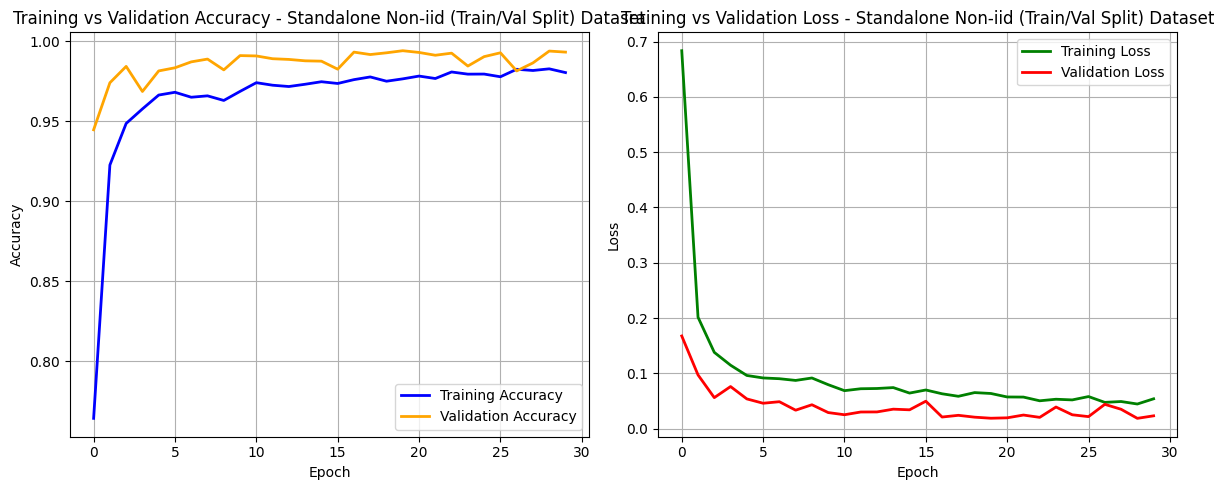

2025-07-29 16:26:08,180 [INFO] ✅ Plot saved and displayed successfully.



In [25]:
# === Constants ===
MODEL_TYPE = MODEL_TYPE.capitalize()
DISTRIBUTION = DISTRIBUTION.capitalize()

# === Logging ===
log("📊 Plotting Training vs Validation Accuracy and Loss...")
log(f"📂 Saving plot to: {ACCURACY_LOSS_PLOT_DIR}")
log(f"🔤 Plot title: 'Training vs Validation Accuracy/Loss - {MODEL_TYPE} {DISTRIBUTION} (Train/Val Split)'")

# === Plotting ===
plt.figure(figsize=(12, 5))

# 📈 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy", color='blue', linewidth=2)
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color='orange', linewidth=2)
plt.title(f"Training vs Validation Accuracy - {MODEL_TYPE} {DISTRIBUTION} (Train/Val Split) Dataset")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 📉 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss", color='green', linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss", color='red', linewidth=2)
plt.title(f"Training vs Validation Loss - {MODEL_TYPE} {DISTRIBUTION} (Train/Val Split) Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(ACCURACY_LOSS_PLOT_DIR)
plt.show()

log("✅ Plot saved and displayed successfully.\n")


### 🧪 Evaluate the Model & Plot Confusion Matrix

2025-07-29 16:26:08,189 [INFO] 🧠 Generating predictions on validation set...


144/144 [==============================] - 0s 1ms/step


2025-07-29 16:26:08,603 [INFO] ✅ Predictions completed.
2025-07-29 16:26:08,604 [INFO] 
📄 === Classification Report ===
2025-07-29 16:26:08,616 [INFO]               precision    recall  f1-score   support

         bad       0.99      1.00      0.99      2185
        good       1.00      0.99      0.99      2404

    accuracy                           0.99      4589
   macro avg       0.99      0.99      0.99      4589
weighted avg       0.99      0.99      0.99      4589

2025-07-29 16:26:08,616 [INFO] 🔢 Generating confusion matrix...


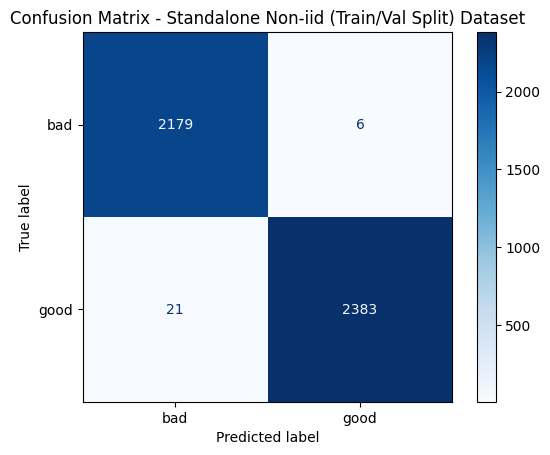

2025-07-29 16:26:08,797 [INFO] ✅ Confusion matrix saved to ../../resources/plot/standalone/test-train-split-data/non-IID/confusion_matrix.png



In [26]:
# === Predict on Validation Set ===
log("🧠 Generating predictions on validation set...")
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
log("✅ Predictions completed.")

# === Classification Report ===
log("\n📄 === Classification Report ===")
report = classification_report(y_val, y_pred, target_names=LABEL_MAP.keys())
log(report)

# === Confusion Matrix ===
log("🔢 Generating confusion matrix...")
cm = confusion_matrix(y_val, y_pred)

MODEL_TYPE_CAP = MODEL_TYPE.capitalize()
DISTRIBUTION_CAP = DISTRIBUTION.capitalize()

# === Plot and Save ===
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABEL_MAP.keys())
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {MODEL_TYPE_CAP} {DISTRIBUTION_CAP} (Train/Val Split) Dataset")
plt.savefig(CONFUSION_MATRIX_PLOT_DIR)
plt.show()

log(f"✅ Confusion matrix saved to {CONFUSION_MATRIX_PLOT_DIR}\n")


### 📦 Save model

In [27]:
# === Save the Model ===
log("💾 Saving model...")
model.save(MODEL_SAVE_PATH)
log(f"✅ Model saved at: {MODEL_SAVE_PATH}")

# === End of Logging ===
log(f"📘 === Logs Ended @ [{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] ===")


2025-07-29 16:26:08,804 [INFO] 💾 Saving model...
2025-07-29 16:26:08,840 [INFO] ✅ Model saved at: ../../model/standalone_non-IID_model.h5
2025-07-29 16:26:08,841 [INFO] 📘 === Logs Ended @ [2025-07-29 16:26:08] ===
